In [11]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:


# Hämta från databasen
conn = sqlite3.connect("matkassen_data.db")
df_final = pd.read_sql("SELECT * FROM processed_training_data", conn)
conn.close()


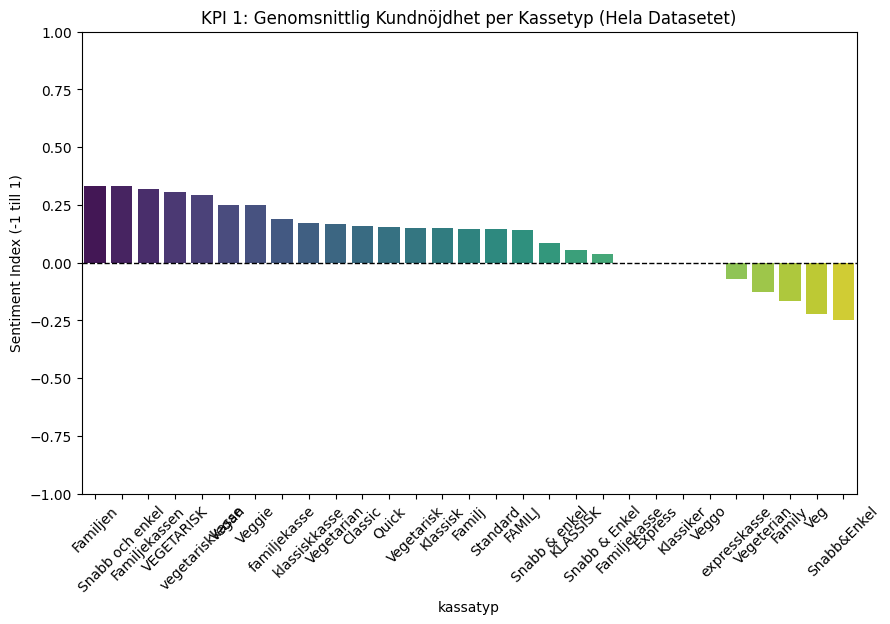

In [13]:

# Vi lägger till .dropna() för att vara säkra på att vi bara räknar rader med sentiment.
sentiment_kpi = df_final.dropna(subset=['feat_sentiment_index']).groupby('kassatyp')['feat_sentiment_index'].mean().sort_values(ascending=False)

# 2. Visualisering
plt.figure(figsize=(10, 6))

#  Vi lägger till'hue' för att undvika varningar i nyare Seaborn.
sns.barplot(
    x=sentiment_kpi.index, 
    y=sentiment_kpi.values, 
    palette="viridis", 
    hue=sentiment_kpi.index, 
    legend=False
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(-1, 1) # Sätter skalan för att visa hela spannet -1 till 1
plt.title("KPI 1: Genomsnittlig Kundnöjdhet per Kassetyp (Hela Datasetet)")
plt.ylabel("Sentiment Index (-1 till 1)")
plt.xticks(rotation=45) # Gör det lättare att läsa kassetyp-namnen
plt.show()

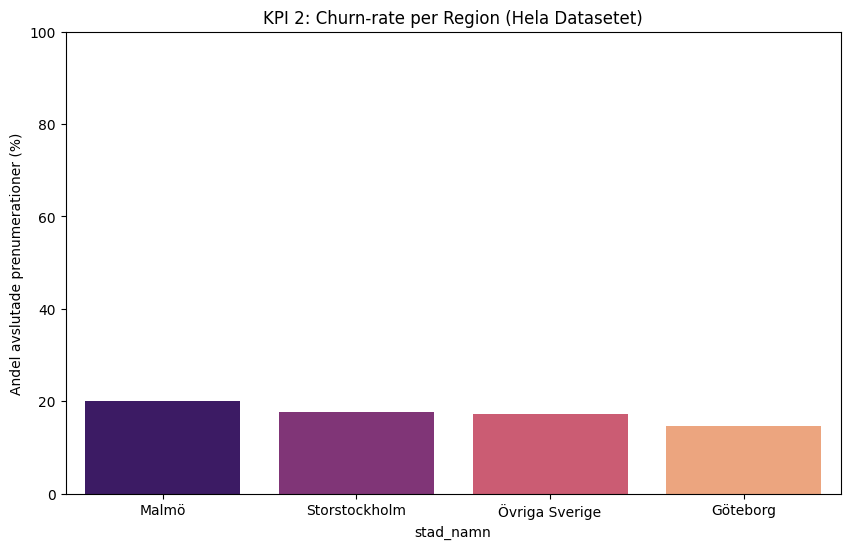

--- CHURN PER REGION (%) ---
stad_namn
Malmö             20.000000
Storstockholm     17.759146
Övriga Sverige    17.223650
Göteborg          14.733542
Name: har_avslutat, dtype: float64


In [14]:

# Vi räknar ut medelvärdet av 'har_avslutat' (0 eller 1) vilket ger andelen churn
churn_kpi = df_final.groupby('stad_namn')['har_avslutat'].mean().sort_values(ascending=False) * 100

# 2. Visualisering
plt.figure(figsize=(10, 6))
#  Vi lägger till hue för att undvika varningar
sns.barplot(x=churn_kpi.index, y=churn_kpi.values, palette="magma", hue=churn_kpi.index, legend=False)

plt.title("KPI 2: Churn-rate per Region (Hela Datasetet)")
plt.ylabel("Andel avslutade prenumerationer (%)")
plt.ylim(0, 100) # Sätter skalan till 0-100% för tydlighet
plt.show()

print("--- CHURN PER REGION (%) ---")
print(churn_kpi)

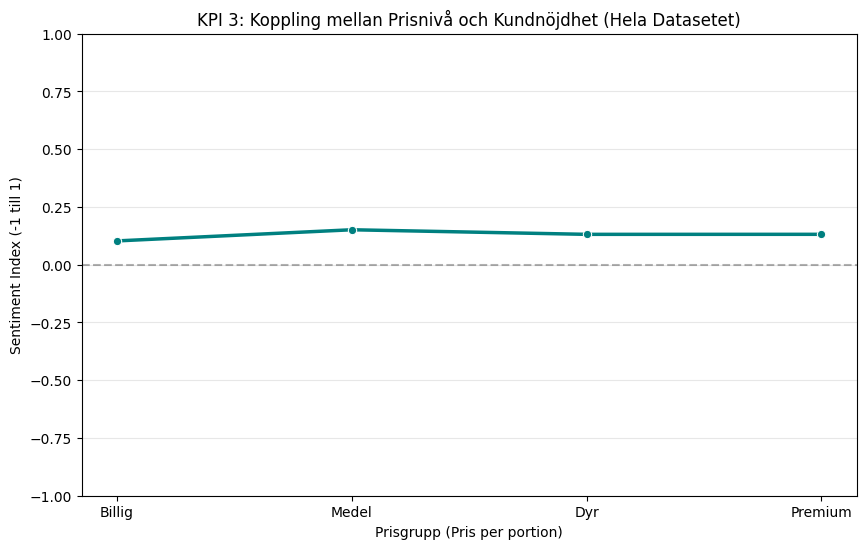

--- SNITTPRERENTIMENT PER PRISGRUPP ---
pris_grupp
Billig     0.103037
Medel      0.151345
Dyr        0.131503
Premium    0.131619
Name: feat_sentiment_index, dtype: float64


In [15]:
# 1. Använd df_final och rensa bort rader utan pris/sentiment för en korrekt analys
df_analysis = df_final.dropna(subset=['pris_per_portion', 'feat_sentiment_index']).copy()

# 2. Delar upp priset i grupper baserat på hela datasetet
# q=4 delar upp kunderna i fyra lika stora grupper (kvartiler)
df_analysis['pris_grupp'] = pd.qcut(df_analysis['pris_per_portion'], q=4, labels=['Billig', 'Medel', 'Dyr', 'Premium'])

# 3. Beräkna genomsnittligt sentiment per prisgrupp
price_sentiment = df_analysis.groupby('pris_grupp')['feat_sentiment_index'].mean()

# 4. Visualisering
plt.figure(figsize=(10, 6))
sns.lineplot(x=price_sentiment.index, y=price_sentiment.values, marker='o', color='teal', linewidth=2.5)

# Förtydliga grafen
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.ylim(-1, 1) 
plt.title("KPI 3: Koppling mellan Prisnivå och Kundnöjdhet (Hela Datasetet)")
plt.ylabel("Sentiment Index (-1 till 1)")
plt.xlabel("Prisgrupp (Pris per portion)")
plt.grid(axis='y', alpha=0.3)
plt.show()

print("--- SNITTPRERENTIMENT PER PRISGRUPP ---")
print(price_sentiment)

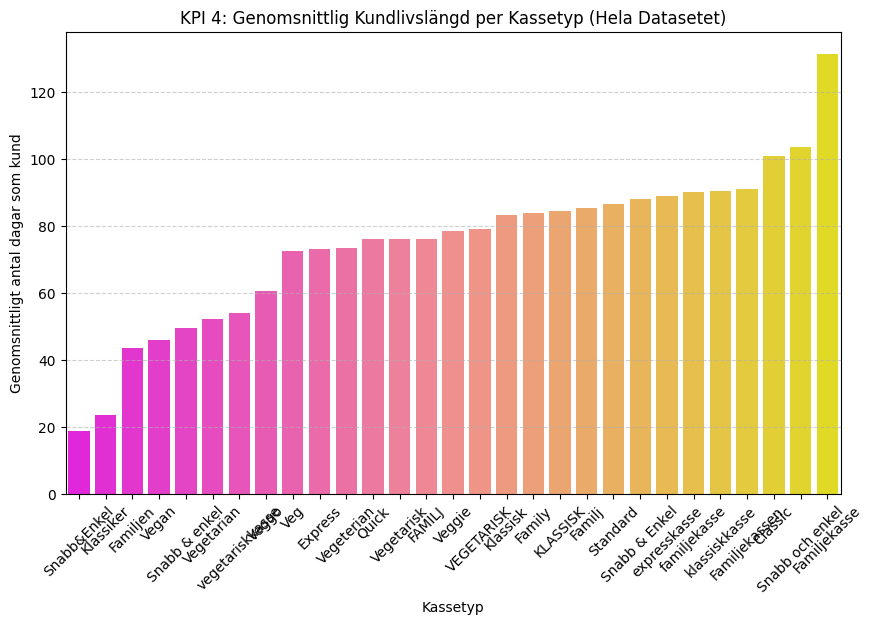

--- GENOMSNITTLIG LOJALITET (DAGAR) ---
kassatyp
Snabb&Enkel         18.8
Klassiker           23.5
Familjen            43.7
Vegan               45.9
Snabb & enkel       49.5
Vegetarian          52.1
vegetariskkasse     54.1
Veggo               60.7
Veg                 72.5
Express             73.1
Vegeterian          73.4
Quick               76.0
Vegetarisk          76.2
FAMILJ              76.2
Veggie              78.4
VEGETARISK          79.1
Klassisk            83.2
Family              84.0
KLASSISK            84.5
Familj              85.5
Standard            86.6
Snabb & Enkel       87.9
expresskasse        89.1
familjekasse        90.2
klassiskkasse       90.5
Familjekassen       91.0
Classic            101.0
Snabb och enkel    103.7
Familjekasse       131.5
Name: feat_kundalder_dagar, dtype: float64


In [16]:
# 1. Använder df_final för hela datasetet
# Vi filtrerar så vi bara ser kunder med en ålder på 0 dagar eller mer
lojalitet_kpi = df_final[df_final['feat_kundalder_dagar'] >= 0].groupby('kassatyp')['feat_kundalder_dagar'].mean().sort_values()

# 2. Visualisering
plt.figure(figsize=(10, 6))

sns.barplot(
    x=lojalitet_kpi.index, 
    y=lojalitet_kpi.values, 
    palette="spring", 
    hue=lojalitet_kpi.index, 
    legend=False
)

plt.title("KPI 4: Genomsnittlig Kundlivslängd per Kassetyp (Hela Datasetet)")
plt.ylabel("Genomsnittligt antal dagar som kund")
plt.xlabel("Kassetyp")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("--- GENOMSNITTLIG LOJALITET (DAGAR) ---")
print(lojalitet_kpi.round(1))

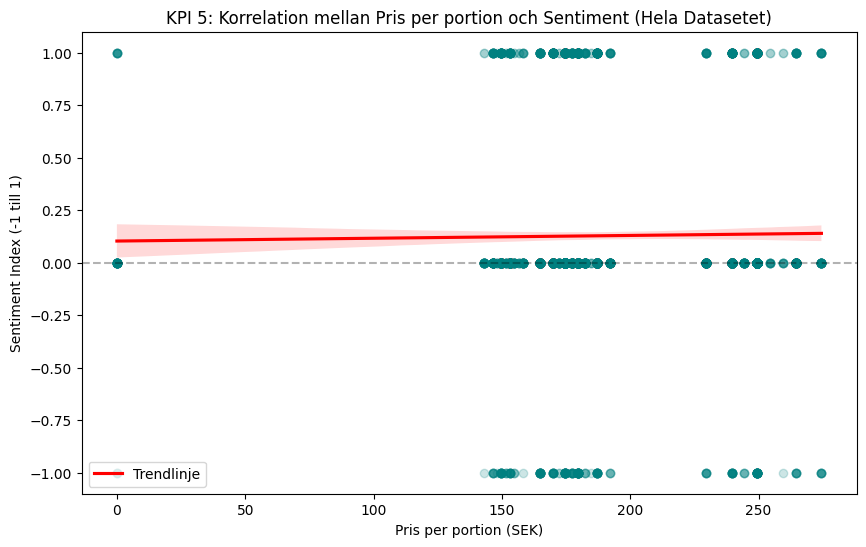

Statistisk korrelation (Pearson): 0.0112


In [17]:
# 1. Använd df_final och ta bort rader där pris eller sentiment saknas
# Detta säkerställer att regplot kan räkna ut korrelationslinjen korrekt
df_plot = df_final.dropna(subset=['pris_per_portion', 'feat_sentiment_index'])

# 2. Visualisering
plt.figure(figsize=(10, 6))

# sns.regplot ritar både punkterna (scatter) och en röd trendlinje (regression)
sns.regplot(
    data=df_plot, 
    x='pris_per_portion', 
    y='feat_sentiment_index', 
    scatter_kws={'alpha':0.2, 'color':'teal'}, # Lägre alpha gör det lättare att se densitet
    line_kws={'color':'red', 'label':'Trendlinje'}
)

plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.ylim(-1.1, 1.1)
plt.title("KPI 5: Korrelation mellan Pris per portion och Sentiment (Hela Datasetet)")
plt.ylabel("Sentiment Index (-1 till 1)")
plt.xlabel("Pris per portion (SEK)")
plt.legend()
plt.show()

# 3. Räknar ut det faktiska korrelationsvärdet.
correlation = df_plot['pris_per_portion'].corr(df_plot['feat_sentiment_index'])
print(f"Statistisk korrelation (Pearson): {correlation:.4f}")

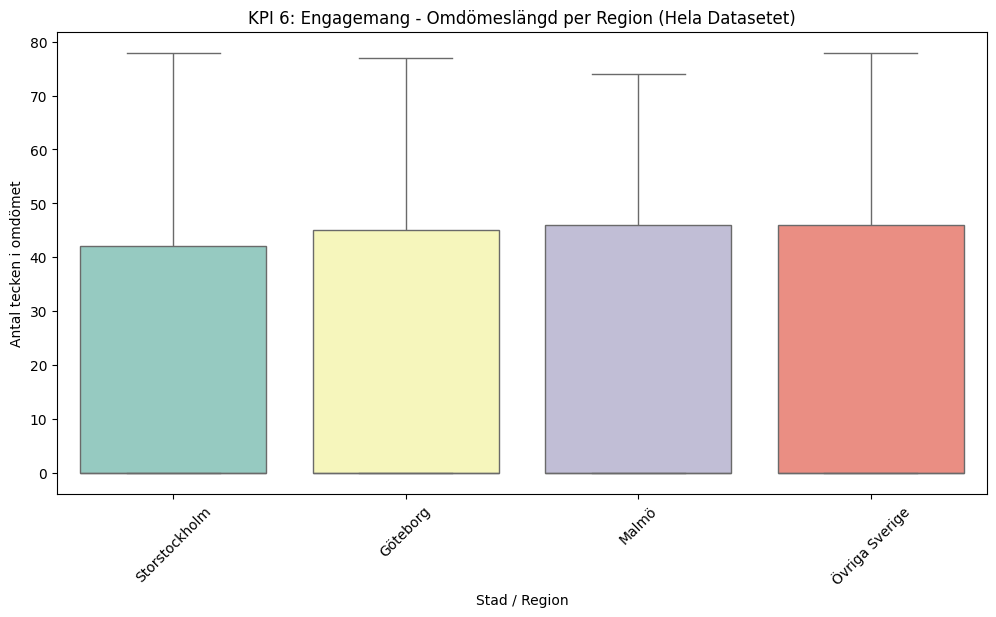

--- GENOMSNITTLIG TEXTLÄNGD PER STAD ---
stad_namn
Övriga Sverige    19.895887
Göteborg          19.672414
Malmö             19.502913
Storstockholm     17.639482
Name: omdome_langd, dtype: float64


In [18]:
# 1. Använd df_final för hela datasetet
# Vi filtrerar bort de som inte skrivit något alls om vi vill se den faktiska skrivlängden
df_skrivande = df_final[df_final['omdome_langd'] > 0]

# 2. Visualisering
plt.figure(figsize=(12, 6))

# Boxplot visar median, kvartiler och extremvärden
sns.boxplot(
    data=df_final, 
    x='stad_namn', 
    y='omdome_langd', 
    palette="Set3",
    hue='stad_namn',
    legend=False
)

plt.title("KPI 6: Engagemang - Omdömeslängd per Region (Hela Datasetet)")
plt.ylabel("Antal tecken i omdömet")
plt.xlabel("Stad / Region")
plt.xticks(rotation=45)

# Vi begränsar y-axeln något om det finns extrema outliers som förstör skalan
# plt.ylim(0, df_final['omdome_langd'].quantile(0.95)) 

plt.show()

# Beräkna snittet för utskrift
print("--- GENOMSNITTLIG TEXTLÄNGD PER STAD ---")
print(df_final.groupby('stad_namn')['omdome_langd'].mean().sort_values(ascending=False))

--- KPI: Engagemang (längd omdöme) vs. Churn (Hela Datasetet) ---
har_avslutat
Kvarvarande    18.620370
Avslutade      20.715576
Name: omdome_langd, dtype: float64


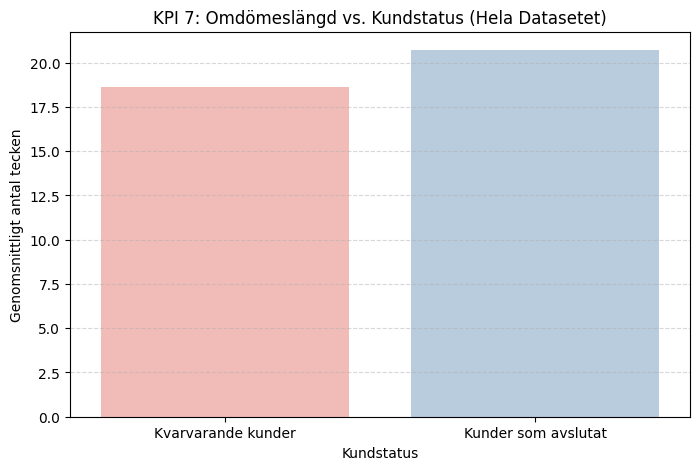

In [9]:
# 1. Använd df_final för att inkludera hela den städade kundbasen
# Vi beräknar snittet på omdömeslängden grupperat på churn-status (0 eller 1)
engagement_churn_kpi = df_final.groupby('har_avslutat')['omdome_langd'].mean()

print("--- KPI: Engagemang (längd omdöme) vs. Churn (Hela Datasetet) ---")
# Vi mappar index för utskriften så det blir tydligt
print(engagement_churn_kpi.rename(index={0: "Kvarvarande", 1: "Avslutade"}))

# 2. Visualisering
plt.figure(figsize=(8, 5))

# Vi skapar grafen
sns.barplot(
    x=engagement_churn_kpi.index, 
    y=engagement_churn_kpi.values, 
    palette="Pastel1",
    hue=engagement_churn_kpi.index,
    legend=False
)

# Snyggar till axlar och titlar
plt.title("KPI 7: Omdömeslängd vs. Kundstatus (Hela Datasetet)")
plt.xlabel("Kundstatus")
plt.ylabel("Genomsnittligt antal tecken")
plt.xticks(ticks=[0, 1], labels=["Kvarvarande kunder", "Kunder som avslutat"])

# Lägg till ett rutnät för att lättare läsa av värdena
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [10]:
#Aggregarad Sentiment KPI
overall_sentiment_kpi = np.nanmean(df_final['feat_sentiment_index'])

# Skriv ut resultatet formaterat till 3 decimaler
print(f"--- ALLMÄNT OMDÖME FÖR HELA DATASETET ---")
print(f"Genomsnittligt Sentiment Index: {overall_sentiment_kpi:.3f}")

--- ALLMÄNT OMDÖME FÖR HELA DATASETET ---
Genomsnittligt Sentiment Index: 0.128
